## version3: 10/25 –

### Library

In [110]:
# import libraries
import os
import math
import time
import yaml
import datetime 
import numpy as np
import pandas as pd
from tqdm import trange
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer

# set random seed
fix_seed = 1111
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)

# set device 
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


### Import parameters and data

In [111]:
# load parameters
with open('/Users/koki/PycharmProjects/MasterThesis/params/config_transformer.yml', 'r') as yml:
    yaml_data = yaml.safe_load(yml)

In [112]:
# import data
df = pd.read_csv('/Users/koki/PycharmProjects/MasterThesis/data/preprocessed/201601to202309_10areas_for_analysis.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
# choose hours to use
time_list = yaml_data['dataset']['time_list']
if time_list != 'all':
    df = df.loc[df.index.hour.isin(time_list)]

### Define dataset

In [113]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, seq_len_src=56, seq_len_tgt=8, lag_len=8):
        self.seq_len_src = seq_len_src
        self.lag_len = lag_len
        self.seq_len_tgt = seq_len_tgt
        self.df = torch.tensor(dataframe.values).float()
        self.len = math.floor((len(self.df) - self.seq_len_src - self.seq_len_tgt) / self.lag_len) + 1

    def __len__(self):
        return self.len

    def __getitem__(self, i):
        if type(i) == slice:
            raise Exception('Exception: Expected int, inputted slice!')
            
        X = self.df[i*self.lag_len:i*self.lag_len+self.seq_len_src]
        Y = self.df[i*self.lag_len+self.seq_len_src:i*self.lag_len+self.seq_len_src+self.seq_len_tgt]
        
        return X, Y
    
    def input_size(self):
        return self.df.shape[1]

### Split data

In [114]:
batch_size = yaml_data['dataset']['batch_size']
seq_len_src = yaml_data['dataset']['seq_len_src']
seq_len_tgt = yaml_data['dataset']['seq_len_tgt']
lag_len = yaml_data['dataset']['lag_len']

# set start dates and end dates
train_start = yaml_data['dataset']['train_start']
train_end = yaml_data['dataset']['train_end']
valid_start = yaml_data['dataset']['valid_start']
valid_end = yaml_data['dataset']['valid_end']
test_start = yaml_data['dataset']['test_start']
test_end = yaml_data['dataset']['test_end']

# split df into train, valid and test data
df_train = df.loc[train_start:train_end].copy()
df_valid = df.loc[valid_start:valid_end].copy()
df_test = df.loc[test_start:test_end].copy()

# df for prediction
df_valid_for_pred = pd.concat([df_train.iloc[-seq_len_src:, :], df_valid])  # valid_dataの1期目から予測するために、前日もテストデータに含める。
df_test_for_pred = pd.concat([df_valid.iloc[-seq_len_src:, :], df_test])  # test_dataの1期目から予測するために、前日もテストデータに含める。

# print the fraction of each dataset
print("Train set fraction: {:.3f}%".format(len(df_train)/len(df)*100))
print("Valid set fraction: {:.3f}%".format(len(df_valid)/len(df)*100))
print("Test set fraction: {:.3f}%".format(len(df_test)/len(df)*100))

Train set fraction: 77.456%
Valid set fraction: 12.898%
Test set fraction: 9.647%


### Set dataloader

In [115]:
# create dataset
train_dataset = SequenceDataset(df_train, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=1)
valid_dataset = SequenceDataset(df_valid, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)
test_dataset = SequenceDataset(df_test, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)

# dataset for prediction
valid_dataset_for_pred = SequenceDataset(df_valid_for_pred, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)
test_dataset_for_pred = SequenceDataset(df_test_for_pred, seq_len_src=seq_len_src, seq_len_tgt=seq_len_tgt, lag_len=lag_len)

print("Length of each dataset:")
print("    Train:{}, Valid:{}, Test:{}".format(len(train_dataset), len(valid_dataset), len(test_dataset)))

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0, pin_memory=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0, pin_memory=True)

# check the shape of a batch
X, y = next(iter(train_loader))
print("Features shape:", X.shape)  # [batch size, sequence length, number of features]
print("Target shape:", y.shape)

Length of each dataset:
    Train:8737, Valid:358, Test:266
Features shape: torch.Size([128, 28, 66])
Target shape: torch.Size([128, 4, 66])


### Define embedding

In [116]:
#位置エンコーディングの定義
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

#モデルに入力するために次元を拡張することを自然言語処理でいうエンべディングとしました
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model) 

    def forward(self, x):
        x = self.tokenConv(x)
        return x

### Define Transformer

In [117]:
class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers,
        d_model, d_output,
        dim_feedforward = 512, dropout = 0.1, nhead = 8):
        
        super(Transformer, self).__init__()
        

        #エンべディングの定義
        # self.token_embedding_src = TokenEmbedding(d_input, d_model)
        # self.token_embedding_tgt = TokenEmbedding(d_output, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        #エンコーダの定義
        encoder_layer = TransformerEncoderLayer(d_model=d_model, 
                                                nhead=nhead, 
                                                dim_feedforward=dim_feedforward,
                                                dropout=dropout,
                                                batch_first=True,
                                                activation='gelu'
                                               )
        encoder_norm = LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, 
                                                      num_layers=num_encoder_layers,
                                                      norm=encoder_norm
                                                     )
        
        #デコーダの定義
        decoder_layer = TransformerDecoderLayer(d_model=d_model, 
                                                nhead=nhead, 
                                                dim_feedforward=dim_feedforward,
                                                dropout=dropout,
                                                batch_first=True,
                                                activation='gelu'
                                               )
        decoder_norm = LayerNorm(d_model)
        self.transformer_decoder = TransformerDecoder(decoder_layer, 
                                                      num_layers=num_decoder_layers, 
                                                      norm=decoder_norm)
        
        #出力層の定義
        self.output = nn.Linear(d_model, d_output)
        

    def forward(self, src, tgt, mask_src, mask_tgt):
        #mask_src, mask_tgtはセルフアテンションの際に未来のデータにアテンションを向けないためのマスク
        
        embedding_src = self.positional_encoding(src)
        memory = self.transformer_encoder(embedding_src, mask_src)
        
        embedding_tgt = self.positional_encoding(tgt)
        outs = self.transformer_decoder(embedding_tgt, memory, mask_tgt)
        
        output = self.output(outs)
        return output

    def encode(self, src, mask_src):
        return self.transformer_encoder(self.positional_encoding(src), mask_src)

    def decode(self, tgt, memory, mask_tgt):
        return self.transformer_decoder(self.positional_encoding(tgt), memory, mask_tgt)


### Define masks

In [118]:
def create_mask(src, tgt):
    
    seq_len_src = src.shape[1]
    seq_len_tgt = tgt.shape[1]

    mask_tgt = generate_square_subsequent_mask(seq_len_tgt).to(device)
    mask_src = generate_square_subsequent_mask(seq_len_src).to(device)

    return mask_src, mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
    return mask


### Define training, validation, and prediction

In [127]:
def train(model, data_loader, optimizer, criterion, num_features_pred):
    model.train()
    total_loss = []
    for src, tgt in data_loader:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        input_tgt = torch.cat((src[:,-1:,:],tgt[:,:-1,:]), dim=1)
        
        mask_src, mask_tgt = create_mask(src, input_tgt)
        
        output = model(src=src, tgt=input_tgt, mask_src=mask_src, mask_tgt=mask_tgt)
        
        optimizer.zero_grad()
        
        loss = criterion(output[:,:,0:num_features_pred], tgt[:,:,0:num_features_pred])
        
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
    
    # change learning rate
    scheduler.step()
        
    return np.average(total_loss)


def validate(model, data_loader, criterion, num_features_pred, loss_calculation):
    model.eval()
    total_loss = []
    for src, tgt in data_loader:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)

        seq_len_src = src.shape[1]
        
        mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
        mask_src = mask_src.float().to(device)
    
        memory = model.encode(src, mask_src)
        outputs = src[:, -1:, :]
        seq_len_tgt = tgt.shape[1]
    
        # ループさせて逐次的に予測する
        for i in range(seq_len_tgt - 1):  # 1期目を入力し2期目以降を予測するので、seq_len_tgt-1する。
        
            mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)
        
            output = model.decode(outputs, memory, mask_tgt)
            output = model.output(output)
            
            # concat predicted population and actual dummies
            output = torch.cat([output[:, -1:, :num_features_pred], tgt[:, i+1:i+2, num_features_pred:]], dim=2)

            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
                
        if loss_calculation == 'all':
            loss = criterion(outputs, tgt)
        elif loss_calculation == 'features_pred':
            loss = criterion(outputs[:,:,0:num_features_pred], tgt[:,:,0:num_features_pred])
        
        total_loss.append(loss.cpu().detach())
        
    return np.average(total_loss)


def predict(model, dataset, num_features_pred):
    model.eval()
    with torch.no_grad():
        all_outputs = torch.zeros(1, 1, df.shape[1]).to(device)
        for t in tqdm(range(len(dataset))):  # (len(df_test)-8)/8 = 92回予測が必要
            src = dataset[t][0].float().to(device)
            tgt = dataset[t][1].float().to(device)

            # add a batch size of 1 for the encoder (= [1, :, :])
            src = src.unsqueeze(0)  
            tgt = tgt.unsqueeze(0)

            seq_len_src = src.shape[1]
            seq_len_tgt = tgt.shape[1]
            
            mask_src = (torch.zeros(seq_len_src, seq_len_src)).type(torch.bool)
            mask_src = mask_src.float().to(device)
            
            memory = model.encode(src, mask_src)
            outputs = src[:, -1:, :]

            #ループさせて逐次的に予測する
            for i in range(seq_len_tgt):

                mask_tgt = (generate_square_subsequent_mask(outputs.size(1))).to(device)

                output = model.decode(outputs, memory, mask_tgt)
                output = model.output(output)  # output.shape = [バッチサイズ1, ウィンドウサイズi(累積される), 変数]

                # convert predicted dummies to the actual ones
                output = torch.cat([output[:, -1:, :num_features_pred], src[:, i:i+1, num_features_pred:]], dim=2)

                # concat outputs and output above
                outputs = torch.cat([outputs, output], dim=1)
                
            all_outputs = torch.cat([all_outputs, outputs[:, 1:, :]], dim=1)

    return all_outputs[-1, 1:, :num_features_pred].to('cpu').detach().numpy()  # all_outputs[-1, 1:, :num_features_pred] → バッチサイズを消す＆all_outputsの最初の0を消す

### Define parameters

In [120]:
# d_input = 1
d_output = train_dataset.input_size()
d_model = train_dataset.input_size()
nhead = yaml_data['model']['nhead'] 
dim_feedforward = yaml_data['model']['dim_feedforward']
num_encoder_layers = yaml_data['model']['num_encoder_layers']
num_decoder_layers = yaml_data['model']['num_decoder_layers']
dropout = yaml_data['model']['dropout']
epochs = yaml_data['training']['n_epochs']
learning_rate = yaml_data['training']['learning_rate']
num_features_pred=yaml_data['training']['num_features_pred']
milestones = yaml_data['training']['milestones']
gamma = yaml_data['training']['gamma']

model = Transformer(num_encoder_layers=num_encoder_layers,
                    num_decoder_layers=num_decoder_layers,
                    d_model=d_model,
                    d_output=d_output,
                    dim_feedforward=dim_feedforward,
                    dropout=dropout, nhead=nhead)

# for p in model.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

model = model.to(device)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

### Training

In [121]:
start = time.time()
train_losses = []
with trange(epochs) as tr:
    for epoch in tr:
        # train
        loss_train = train(model=model, 
                           data_loader=train_loader, 
                           optimizer=optimizer,
                           criterion=criterion, 
                           num_features_pred=num_features_pred)
        # convert to RMSE
        loss_train = math.sqrt(loss_train)
        # append epoch loss
        train_losses.append(loss_train)  
        # progress bar 
        tr.set_postfix(Train_loss="{0:.3f}".format(loss_train))

# calculate execution time
end = time.time()
t = math.floor(end-start)
elapsed_hour = t // 3600
elapsed_minute = (t % 3600) // 60
elapsed_second = (t % 3600 % 60)
elapsed_time = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)

 34%|█████████████████████████████████▏                                                                | 271/800 [18:44<36:35,  4.15s/it, Train_loss=20920.993]


KeyboardInterrupt: 

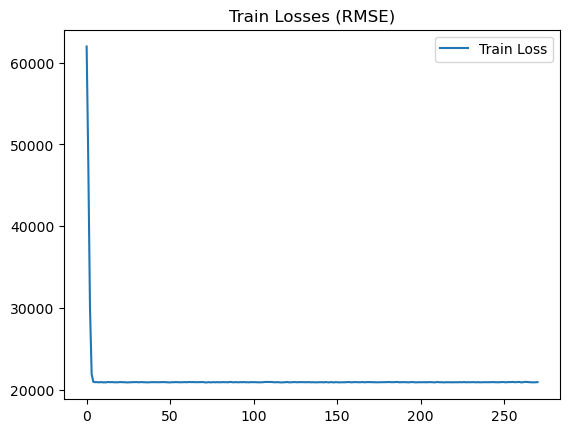

In [122]:
plt.plot(train_losses, label='Train Loss')
plt.title('Train Losses (RMSE)')
plt.legend()
plt.show()

### (Load a past model)

In [123]:
'''
This code is used only for loading the model and checking its prediction.
'''
# # set name of the model
# model_num = 20

# # load the model and its loss
# model = torch.load('/Users/koki/PycharmProjects/MasterThesis/models/model_' + str(model_num).zfill(2) + '.pth')
# loss = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='losses', usecols=[model_num-1])
# train_losses = loss.iloc[:,0].to_list()

'\nThis code is used only for loading the model and checking its prediction.\n'

### Predict

In [128]:
num_features_pred = yaml_data['training']['num_features_pred']

# make y_pred df
pred = predict(model = model, dataset = valid_dataset_for_pred, num_features_pred = num_features_pred)
y_pred = pd.DataFrame(pred, columns=df.columns[:num_features_pred], index=df_valid.index).add_prefix('pred_')

  0%|          | 0/365 [00:00<?, ?it/s]

### Calculate RMSE and MAE (predicted values and actual values)

In [131]:
rmse, mae = {}, {}
for i in range(y_pred.shape[1]):
    rmse[df.columns[i]] = mean_squared_error(df_valid.iloc[:,i], y_pred.iloc[:,i], squared=False)
    mae[df.columns[i]] = mean_absolute_error(df_valid.iloc[:,i], y_pred.iloc[:,i])

rmse_pre_actu = pd.Series(rmse)
mae_pre_actu = pd.Series(mae)

print('------------RMSE------------')
print(rmse_pre_actu)
print('Average :', np.mean(rmse_pre_actu))
print('------------MAE-------------')
print(mae_pre_actu)
print('Average :', np.mean(mae_pre_actu))

------------RMSE------------
渋谷駅_total      25545.350314
新宿駅_total      26035.517605
町田駅_total       6283.802950
川崎駅_total       6015.015639
立川駅_total       8175.615599
八王子駅_total      2749.385548
北千住駅_total      4311.957049
東京駅_total      36613.121110
赤羽駅_total       2925.031010
自由が丘駅_total     3537.890806
dtype: float64
Average : 12219.268762812426
------------MAE-------------
渋谷駅_total      21245.799422
新宿駅_total      19878.045719
町田駅_total       4622.022349
川崎駅_total       4413.533792
立川駅_total       6602.712875
八王子駅_total      2290.141042
北千住駅_total      3600.909910
東京駅_total      27525.800771
赤羽駅_total       2395.914453
自由が丘駅_total     2844.065258
dtype: float64
Average : 9541.894559075343


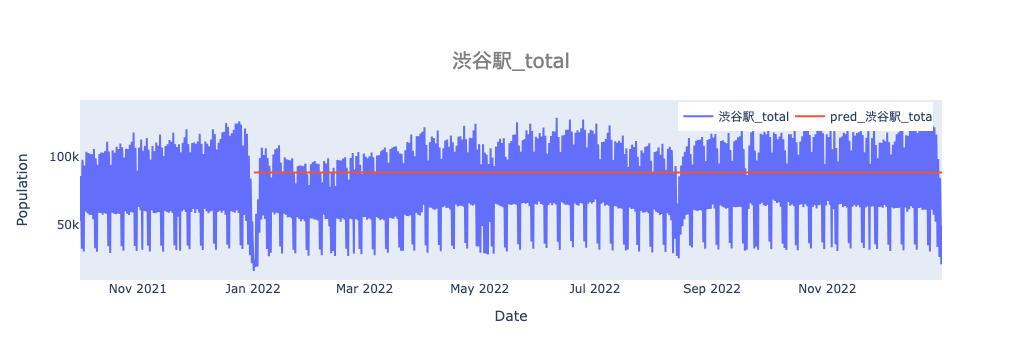

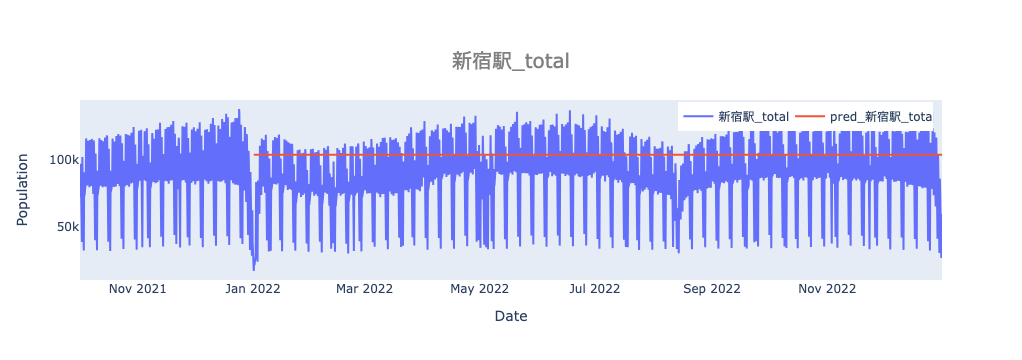

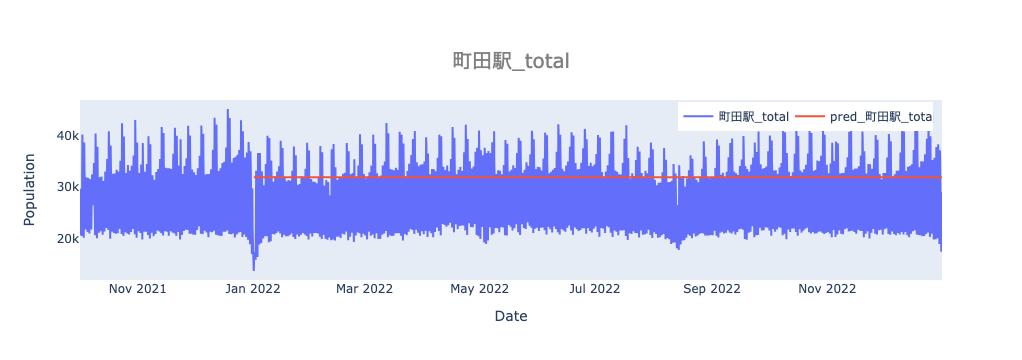

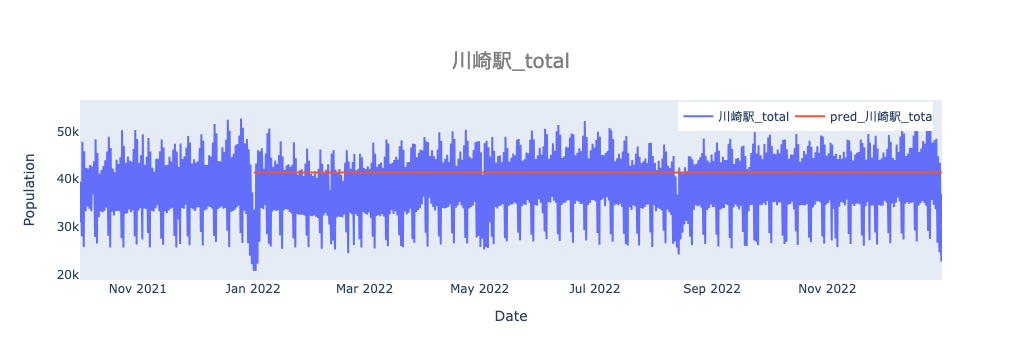

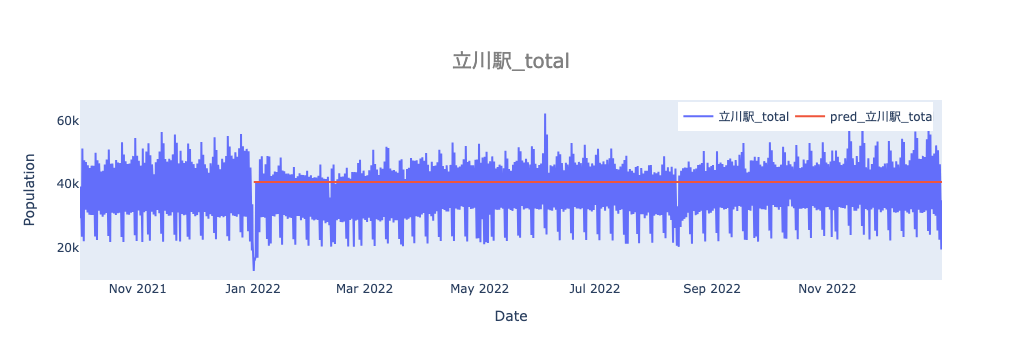

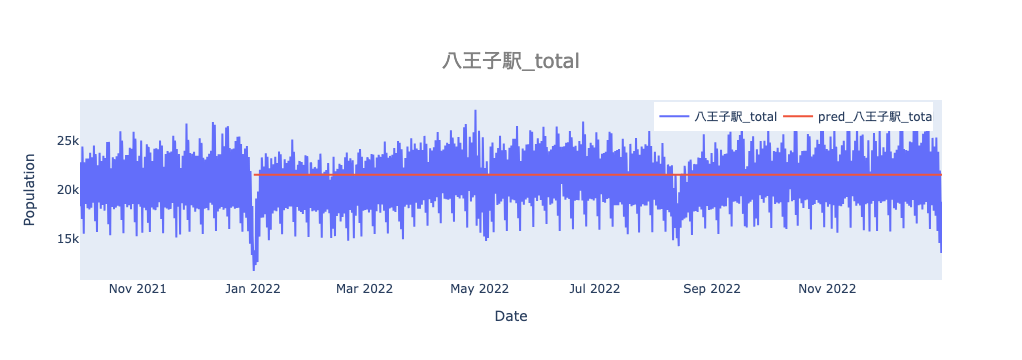

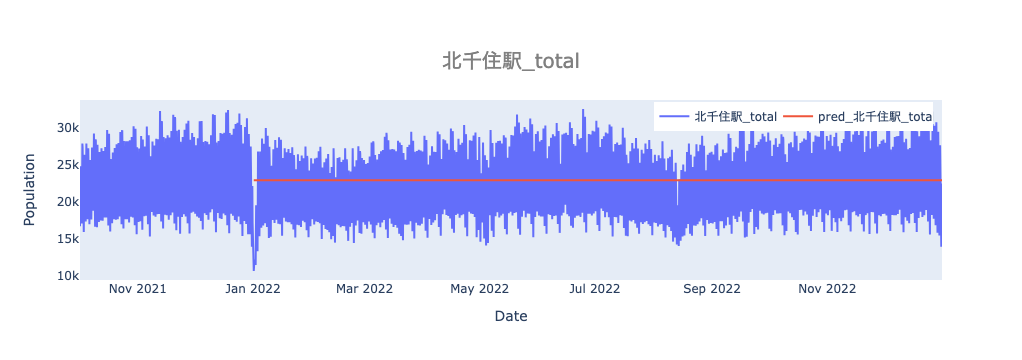

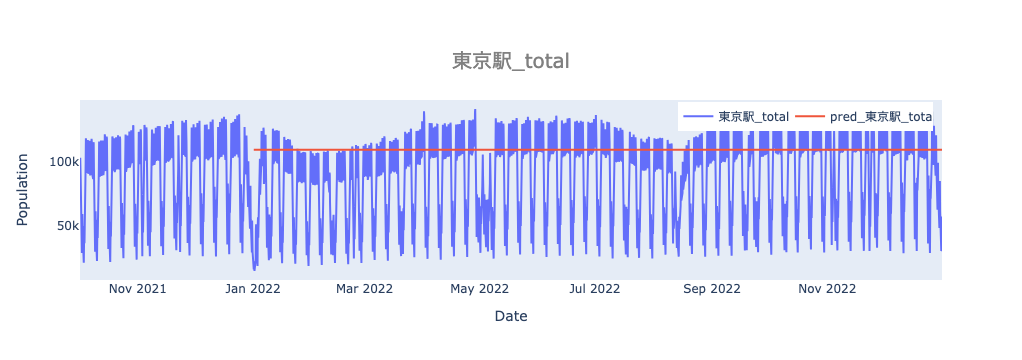

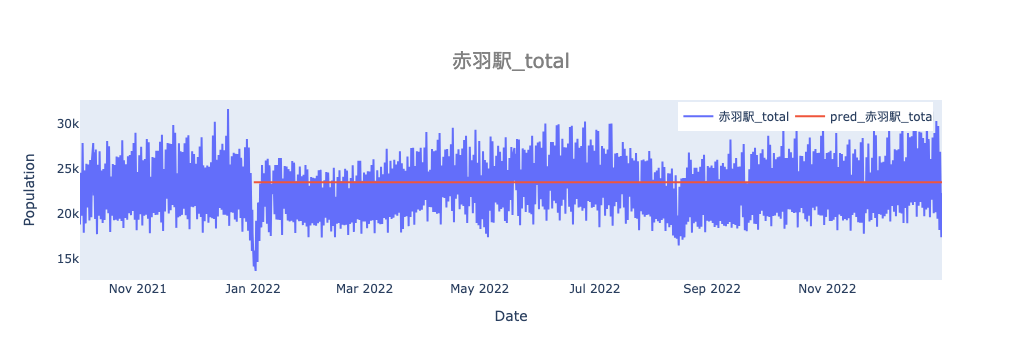

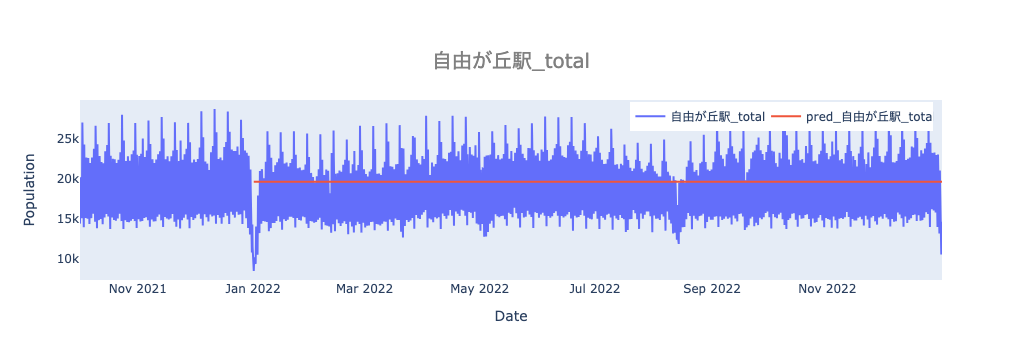

In [132]:
# make y_true df from a specific date
_df_train = df_train.loc['2021-10-01': ,:]
y_true = pd.concat([_df_train, df_valid]).iloc[:, :num_features_pred]

# plot with plotly     
for i in range(y_pred.shape[1]):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true.index, y=y_true.iloc[:, i], name=y_true.columns[i]))
    fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred.iloc[:, i], name=y_pred.columns[i]))
    fig.update_xaxes(title="Date",showgrid=False)
    fig.update_yaxes(title="Population", showgrid=False)
    fig.update_layout(legend=dict(x=0.99,
                              y=0.99,
                              xanchor='right',
                              yanchor='top',
                              orientation='h',
                              ),
                      hovermode='x unified',
                      title=dict(text=y_true.columns[i],
                                 font=dict(size=20, color='grey'),
                                 xref='paper', # container or paper
                                 x=0.5,
                                 y=0.85,
                                 xanchor='center'
                                )
                     )
    fig.show()

### Calculate RMSE and MAE (benchmark and actual values)

In [133]:
# df setup
num_features_pred = yaml_data['training']['num_features_pred']
df_bench_pred = pd.DataFrame([], columns=df.columns[:num_features_pred])
df_bench_true = pd.DataFrame([], columns=df.columns[:num_features_pred])

# month range and dow lists
bench_range = pd.date_range(start=valid_start, end=valid_end, freq='M')
dow_list = ['dow_Mon','dow_Tue','dow_Wed','dow_Thu','dow_Fri','dow_Sat', 'dow_Sun']

# get data from df_train/df_valid and compute mean
for month in bench_range:
    m = str(int(month.strftime('%m'))) # convert month to the same format as in df
    for dow in dow_list:
        query = f'month_{m} == 1 & {dow} == 1 & official_holiday == 0 & unofficial_holiday == 0' # month, dow, and non-holiday
        df_bench_pred.loc[month.strftime('%Y-%m') + ' ' + dow] = df_train.query(query).iloc[:, :num_features_pred].mean()
        df_bench_true.loc[month.strftime('%Y-%m') + ' ' + dow] = df_valid.query(query).iloc[:, :num_features_pred].mean()

# display(df_bench_pred)
# display(df_bench_true)

# calculate RMSE and MAE
rmse, mae = {}, {}
for i in range(num_features_pred):
    rmse[df.columns[i][:-6]] = mean_squared_error(df_bench_pred.iloc[:, i], df_bench_true.iloc[:, i], squared=False)
    mae[df.columns[i][:-6]] = mean_absolute_error(df_bench_pred.iloc[:, i], df_bench_true.iloc[:, i])

rmse_ben_actu = pd.Series(rmse)
mae_ben_actu = pd.Series(mae)
print('------------RMSE------------')
print(rmse_ben_actu)
print('Average :', np.mean(rmse_ben_actu))
print('------------MAE-------------')
print(mae_ben_actu)
print('Average :', np.mean(mae_ben_actu))

------------RMSE------------
渋谷駅       7848.122436
新宿駅       9840.043982
町田駅       1925.866582
川崎駅       1652.203025
立川駅       1849.590238
八王子駅       770.125098
北千住駅       886.736724
東京駅      21193.220463
赤羽駅       1027.694823
自由が丘駅      638.897746
dtype: float64
Average : 4763.2501115993055
------------MAE-------------
渋谷駅       6151.922158
新宿駅       8199.599494
町田駅       1706.494510
川崎駅       1342.159717
立川駅       1430.606879
八王子駅       583.688513
北千住駅       723.758281
東京駅      17788.057493
赤羽駅        860.785846
自由が丘駅      504.958025
dtype: float64
Average : 3929.2030915314085


### Anomaly detection for each location

### Anomaly detection for Tokyo

In [ ]:
def calc_anomaly_scores(matrix_valid, matrix_test):
    '''
    : calculate anomaly scores at each day by quadratic form
    : matrix_valid :  valid data for calculating mean and variance;  numpy matrix
    : matrix_test  :  predicted test data for getting anomaly scores;  numpy matrix
    : return       :  anomaly_scores; numpy array
    '''
    # compute mean and cov inverse
    mean = matrix_valid.mean(axis=0)
    cov_inv = np.matrix(np.cov(matrix_valid, rowvar=False)).getI()

    # apply quadratic formula to each row of matrix
    output = np.zeros(matrix_test.shape[0])
    for i in range(matrix_test.shape[0]):
        output[i] = ((matrix_test[i] - mean) * cov_inv * np.transpose(matrix_test[i] - mean)).item(0)

    return output


# predict with test data
pred = predict(model = model, dataset = test_dataset_for_pred, num_features_pred = num_features_pred)
y_pred = pd.DataFrame(pred, columns=df.columns[:num_features_pred], index=df_test.index).add_prefix('pred_')

# calculate whole Tokyo population by quadratic form
anomaly_scores = calc_anomaly_scores(np.matrix(df_valid.iloc[:,:num_features_pred]), np.matrix(y_pred)) 
# quad_test = calc_anomaly_scores(np.matrix(df_valid.iloc[:,:num_features_pred]), np.matrix(df_test.iloc[:, :num_features_pred])) いらない？

# calculate the difference
# diff = quad_test_pred - quad_test　いらない？

In [ ]:
# set threshold
threshold = 20  ##### Need to change manually #####

# get df where anomaly_scores > threshold
anomaly_df = df_test[anomaly_scores > threshold]

# get the next datetime when anomaly is detected
anomaly_next_hours = []
for date in anomaly_df.index:
    if date.hour == 18:  ##### Need to change manually #####
        anomaly_next_hours.append(date + datetime.timedelta(hours=15))
    else:
        anomaly_next_hours.append(date + datetime.timedelta(hours=3))

In [ ]:
# make y_true df from a specific date
_df_valid = df_valid.loc['2022-12-01': ,:]
y_true = pd.concat([_df_valid, df_test]).iloc[:, :num_features_pred]

# plot with plotly     
for i in range(y_pred.shape[1]):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true.index, y=y_true.iloc[:, i], name=y_true.columns[i]))
    fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred.iloc[:, i], name=y_pred.columns[i]))
    
    fig.update_xaxes(title="Date",showgrid=False)
    fig.update_yaxes(title="Population", showgrid=False)
    fig.update_layout(legend=dict(x=0.99,
                              y=0.99,
                              xanchor='right',
                              yanchor='top',
                              orientation='h',
                              ),
                      hovermode='x unified',
                      title=dict(text=y_true.columns[i],
                                 font=dict(size=20, color='grey'),
                                 xref='paper', # container or paper
                                 x=0.5,
                                 y=0.85,
                                 xanchor='center'
                                )
                     )
    
    for t, next_t in zip(anomaly_df.index , anomaly_next_hours): 
        fig.add_vrect(
                    x0=t,
                    x1=next_t,
                    fillcolor='pink',
                    opacity=0.9,
                    line_width=0,
                    layer='below'
                    )
    
    fig.show()

### Save the results and the model

In [22]:
'''
save the model, its loss, and params used
'''
# count the number of files in the directory
path = '/Users/koki/PycharmProjects/MasterThesis/models'

# read parameter data
df1 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='params')

# set a model name
num = 'model_' + str(df1.shape[0]+1).zfill(2)

# get params used in this file
series = pd.concat([pd.Series(yaml_data['dataset']), pd.Series(yaml_data['model']), pd.Series(yaml_data['training'])])
params = pd.DataFrame(series).T
params.insert(0, "num", num)
params.insert(1, "file_name", "Transformer_ver3")  ###### the name of this file! ######
params.insert(2, "date_of_execution", datetime.datetime.today().strftime("%Y-%m-%d %H:%M"))
params.insert(3, "execution_time", elapsed_time)
params.insert(params.shape[1], "final_train_loss" , math.floor(train_losses[-1]))
params.insert(params.shape[1], "rmse_pred_actu" , math.floor(np.mean(rmse_pre_actu)))
params.insert(params.shape[1], "mae_pred_actu" , math.floor(np.mean(mae_pre_actu)))
params.insert(params.shape[1], "rmse_ben" , math.floor(0.0))
df1 = pd.concat([df1, params])

# read loss data
df2 = pd.read_excel('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx', sheet_name='train_losses')
df2 = pd.concat([df2, pd.Series(train_losses, name=num)], axis=1)

# export the data 
with pd.ExcelWriter('/Users/koki/PycharmProjects/MasterThesis/data/results.xlsx') as writer:
    df1.to_excel(writer, sheet_name='params', index=False)
    df2.to_excel(writer, sheet_name='train_losses', index=False)

# save the model
torch.save(model, '/Users/koki/PycharmProjects/MasterThesis/models/' + num + '.pth')

In [23]:
# notification
# !afplay '/Users/koki/Documents/セレナと一緒/result_message.m4a'

In [24]:
print("Done!!!")

Done!!!


### Memo

In [ ]:
'''
seq2seqも初期のlstmみたいにダミーを後から線形結合してみる？
positional encodingなど必要かどうかちゃんと検証する必要あり。
もっと時系列予測の論文調べる
リアルタイムに予想するなら、新たな学習データを使ってファインチューニングする？
やっぱりもっとちゃんとtrain,valid,testの分割を考えないと、統計量が違いすぎるかも。


train: 2016/01 – 2021/12 学習
valid: 2022/01 – 2022/12　予測値とベンチマークを比較、予測値と実測値を比較、mseを計算
test: 2023/01 – 2023/09　異常検知

ベンチマーク
 1. trainの1月の曜日ごとの平均を計算（7個の値が出てくる）（祝日等は人流が変わるので抜いて計算）
 2. それをベンチマークから作った1月の予測値とする
 3. 各月について1と2を繰り返す
 
学習用とテスト用でデータセットの作り方を変える
seq_len_src=56の場合
学習用：1期ずつずらしていく
        src: t=1–56, tgt: t=57-64
             t=2-57,      t=58-65
テスト用：1日ずつずらしていく
        src: t=1–56, tgt: t=57-64
             t=9-64,      t=65–72
             
seq_len_src=8の場合
学習用：1期ずつずらしていく
        src: t=1–8, tgt: t=9-16
             t=2-9,      t=10-17
テスト用：1日ずつずらしていく
        src: t=1–8, tgt: t=9-16
             t=9-16,     t=17–24 
             
seq_len_src=28の場合
学習用：1期ずつずらしていく
        src: t=1–28, tgt: t=29-32
             t=2-29,      t=30-33
テスト用：1日ずつずらしていく
        src: t=1–28, tgt: t=29-32
             t=5-32,      t=33–36 
             
[seq2seq]
学習の仕方：
 t=1–8→encoder, t=8,9-15→decoder→t=9-16→loss計算,
 
テストの仕方：
 t=1–8→encoder, t=8→decoder→t=9→decoder→t=10→...→t=15→decoder→t=16

[lstm]
学習の仕方：
 t=1–8→lstm→t=2-9→loss計算,
 
テストの仕方：
 t=1–8→lstm→t=9→lstm→t=10→...→t=16→lstm→t=17

'''

### Questions

In [ ]:
'''
3ヶ月予測は、データセットのtime_stepを3ヶ月に作り直すのか、それとも今のままでただ3ヶ月分予測するだけか。
 - データセットはそのままで、ただ3ヶ月先まで予測すれば良いだけ。
   9/1（t=1,...,8）を入力して9/2（t=9,...,16）を予測したら、次はその予測された9/2（t=9,...,16）を入力して9/3（t=17,...,24）を予測する。
 
lstmの予測はループさせるの？
 - yes
 - 単純なlstmの場合、（t=1,...,8）を入力するとそれぞれの値の一期先（t=2,...,9）を出力するだけなので、やはりループが必要。
　
loss計算を人流だけで行うのは本当に正しい？
 - yes
 - 人流以外を予測するのは理にかなってない。（そうなるとn225も外すべきかも）

異常検知はただ予測値と実測値の差を求めて、それが閾値を超えてたら異常と判断すれば良いの？
 - yes
 - 異常検知の場合validも作る　train:2016-2021, valid:2021-2022, test:2023/01/-2023/09
 - 東京の異常を見るときは、数字を一つにまとめる。（二次形式を作り、validdataの平均分散を用いて計算する。詳しくは写真を参照のこと。）
 - time stepの数を減らす（e.g., 朝昼夕の3期）
 
ベンチマークの作りかたをもっと詳しく
 - 
 
コロナ関連のイベントダミーの作り方（e.g., ワクチン開発された、など）はどう作る。その日以降がずっと1になる？それともその日だけ1？
 - 

validationの使い道
 - 


'''

### Insight

In [ ]:
'''
学習率は0.0001じゃないとダメそう。
バッチが大きいとエポックの進みは早いが学習率を小さくしないと上手くいかず、結果的に収束するまで時間がかかる。
バッチが小さいと学習率は比較的大きくて大丈夫だが、学習が遅い。
'''

### To Do

In [ ]:
'''
コロナダミー作成 done
コロナ関連のイベントダミー作成 done
seq2seq, lstmのコードもいじる
時間によって変わる経済変数をもっと入れる（犯罪数、ドル円レート）
データを2016-2023に増やす done
3ヶ月くらい予測してmseで比較 done
長期予測と比較できるようにbenchmarkを作り直す
訓練データ内にある災害などの日を見て、そこが異常検知できてるかどうか見てみる。
予測値を使って異常検知
リアルタイムに異常検知できるようにする
学習の実行時間もエクセルに載せたい done
'''